# Spatial averaged vector autoregressive model (SAVAR) 

SAVAR is a spatio-temporal model where some regions, the so-called modes, affect each other according to some underlying causal model. Modes are regions with covariant noise. We name components to the weighted average of the modes that affect the value of other modes in future time-steps. 

The model is given by the following expression: 

$$
	y_t^\ell:= \sum_{j=1}^{N}u^{\ell j}\sum_{i=1}^{N}\sum_{\tau=1}^{\tau_{max}}\phi^{ji}(\tau)\sum_{\ell}^{L}w^{i \ell} y_{t-\tau}^\ell+\epsilon^\ell_t
$$

where $y_t^\ell$ is the value of the random variable $y$ at time $t$ at location $\ell$, $u^{\ell j}$ is the coefficient that relates how the $j$-th component contributes to the value of $y^\ell_t$, $\phi^{ji}(\tau)$ is the contribution to the $i$-th component to the $j$-th component at time lag $\tau$, $w^{i\ell}$ is the coefficient that relates how $y^\ell$ contributes to the $i$-th and $\epsilon_t^\ell$ stands for a a noise term where $\epsilon_t^\ell \sim \mathcal{N}(\mu, \Sigma)$ and $\Sigma \in \mathbb{R}^{L\times L}$ is the correlation matrix.

the matrix form is given by

$$
	\mathbf{y}_t = W^+\sum_{\tau=1}^{\tau_{max}}\Phi(\tau) W \mathbf{y}_{t-\tau}+\mathbf{\epsilon}_t
$$

where $\mathbf y^T_t = (y^1_t, \dots, y^L_t)$, $u^{\ell j} \in W^+$, $\phi^{i j}(\tau)\in \Phi(\tau)$, $w^{i\ell} \in W$ and $\epsilon_t^\ell \in \mathbf \epsilon_t$. The matrix $W^+$ is the Moore-Penrose pseudoinvers of $W$. This is, $WW^+W=W$.


In [1]:
import spatial_models as models
import matplotlib.pyplot as plt
from functions import create_random_mode, check_stability
from c_functions import deseason_data, standardize_data, compare_modes

import numpy as np

In [2]:
# Some definitions

nx = 30  
ny = 90 # Each component is 30x30
T = 5000 # Time 

In [3]:
# Setup spatial weights of underlying processes

N = 3 # Three components

noise_weights = np.zeros((N, nx, ny))
modes_weights = np.zeros((N, nx, ny))

# load = 1
spatial_covariance = 0.3    # decrease spatial_covariance if covariance mat not pos. semidef

In [4]:
# We can create the modes with it.
noise_weights = np.zeros((N, nx, ny))
noise_weights[0, :, :30] = create_random_mode((30, 30), random = False)
noise_weights[1, :, 30:60] = create_random_mode((30, 30), random = False)
noise_weights[2, :, 60:] = create_random_mode((30, 30), random = False)

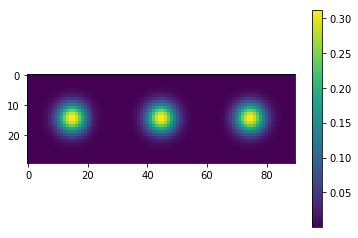

In [5]:
# How the modes look like
plt.imshow(noise_weights.sum(axis=0))
plt.colorbar()

In [6]:
# We can use the same
modes_weights = noise_weights

# Or just assume that the mean value of the whole regions is used.
#noise_weights = np.zeros((N, nx, ny))
#noise_weights[0, :, :30] = 0.01
#noise_weights[1, :, 30:60] = 0.01
#noise_weights[2, :, 60:] = 0.01

# And the causal model
links_coeffs = {
    0: [((0, 1), 0), ((2, 2), -0.4)],
    1: [((1, 1), 0), ((0, 2), 0.4)],
    2: [((2, 1), 0), ((1, 2), 0.4)]
}

# One good thing of SAVAR is that if the underlying process is stable and stationary, then SAVAR is also both. 
# Independently of W. This is, we only need to check for stationarity of \PHI and not of W^+\PHI W
check_stability(links_coeffs)

In [7]:
# This warning tell us that \Sigma is not positive semidefinite We have to change the spatial covariance.
# See: https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multivariate_normal.html
# A good value using create_random_mode is 0.2
spatial_covariance = 0.1
savar = models.savarModel(
    links_coeffs=links_coeffs,
    modes_weights=modes_weights, 
    ny=ny,
    nx=nx,
    T=5000,
    spatial_covariance=spatial_covariance,
    spatial_factor=0.1,
    noise_weights=noise_weights,
    transient = 200, 
    n_variables = N,
    verbose = True
)
savar.create_linear_savar_data()

[[[ 0.   0.   0. ]
  [ 0.   0.   0. ]
  [ 0.  -0.4  0. ]]

 [[ 0.   0.4  0. ]
  [ 0.   0.   0. ]
  [ 0.   0.   0. ]]

 [[ 0.   0.   0. ]
  [ 0.   0.4  0. ]
  [ 0.   0.   0. ]]]
Start...
False


/mnt/c/Users/lenna/Documents/Studie/2019-2020/Scriptie/RGCPD/savar_deliver/spatial_models.py:114: RuntimeWarning: covariance is not positive-semidefinite.
  data_field = np.random.multivariate_normal(mean=np.zeros(ny * nx), cov=cov, size=T+transient)


Compute values in time...
We are inside compute linear savar
Done...


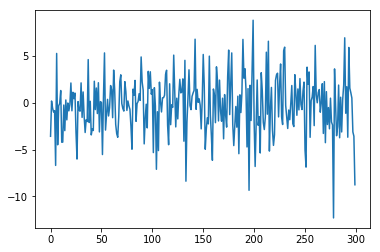

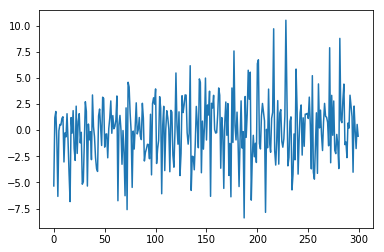

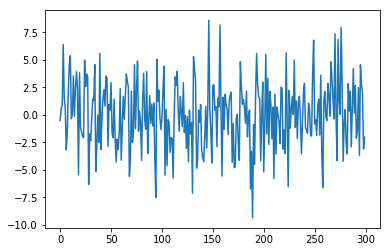

In [8]:
# We can check the time series of one mode
plt.plot(savar.network_data[:300, 0])
plt.show()
plt.plot(savar.network_data[:300, 1])
plt.show()
plt.plot(savar.network_data[:300, 2])
plt.show()

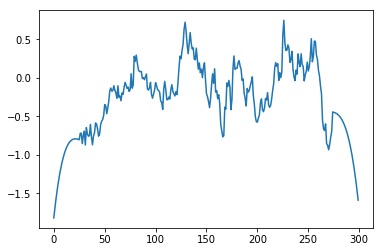

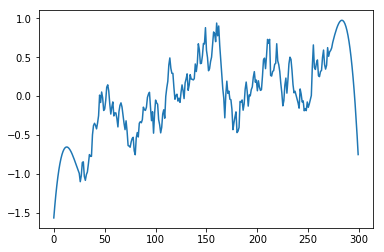

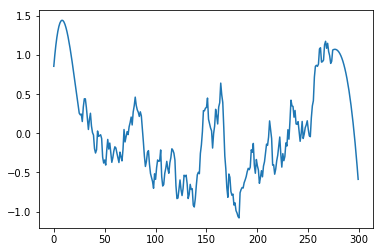

In [9]:
from scipy.signal import savgol_filter
yhat = savgol_filter(savar.network_data[:300, 0], 51, 3) # window size 51, polynomial order 3
plt.plot(yhat)
plt.show()
yhat = savgol_filter(savar.network_data[:300, 1], 51, 3) # window size 51, polynomial order 3
plt.plot(yhat)
plt.show()
yhat = savgol_filter(savar.network_data[:300, 2], 51, 3) # window size 51, polynomial order 3
plt.plot(yhat)
plt.show()

In [10]:
links_coeffs = {
    0: [((0, 1), 0), ((2, 20), 0.9), ((1, 20), 0.9)],
    1: [((1, 1), 0)],
    2: [((2, 1), 0)]
}
check_stability(links_coeffs)

# This warning tell us that \Sigma is not positive semidefinite We have to change the spatial covariance.
# See: https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multivariate_normal.html
# A good value using create_random_mode is 0.2
spatial_covariance = 0.1
savar = models.savarModel(
    links_coeffs=links_coeffs,
    modes_weights=modes_weights, 
    ny=ny,
    nx=nx,
    T=5000,
    spatial_covariance=spatial_covariance,
    spatial_factor=0.1,
    noise_weights=noise_weights,
    transient = 200, 
    n_variables = N,
    verbose = True
)
savar.create_linear_savar_data()

[[[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0. ]
  [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.9 0. ]
  [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.9 0. ]]

 [[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0. ]
  [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0. ]
  [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0. ]]

 [[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0. ]
  [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0. ]
  [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0. ]]]
Start...
False


/mnt/c/Users/lenna/Documents/Studie/2019-2020/Scriptie/RGCPD/savar_deliver/spatial_models.py:114: RuntimeWarning: covariance is not positive-semidefinite.
  data_field = np.random.multivariate_normal(mean=np.zeros(ny * nx), cov=cov, size=T+transient)


Compute values in time...
We are inside compute linear savar
Done...


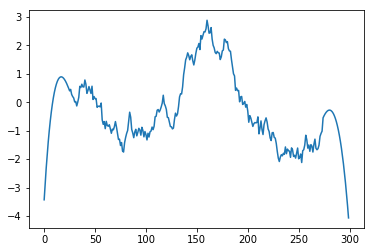

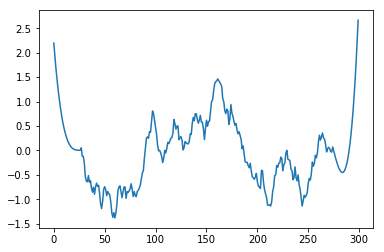

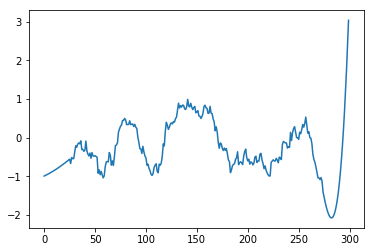

In [11]:
from scipy.signal import savgol_filter
yhat = savgol_filter(savar.network_data[:300, 0], 51, 3) # window size 51, polynomial order 3
plt.plot(yhat)
plt.show()
yhat = savgol_filter(savar.network_data[:300, 1], 51, 3) # window size 51, polynomial order 3
plt.plot(yhat)
plt.show()
yhat = savgol_filter(savar.network_data[:300, 2], 51, 3) # window size 51, polynomial order 3
plt.plot(yhat)
plt.show()

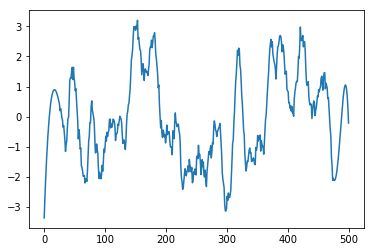

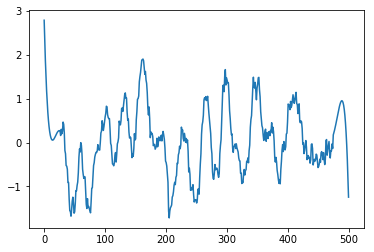

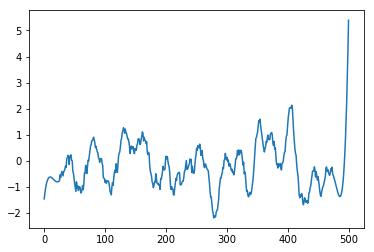

In [12]:
from scipy.signal import savgol_filter
yhat = savgol_filter(savar.network_data[:500, 0], 51, 4) # window size 51, polynomial order 3
plt.plot(yhat)
plt.show()
yhat = savgol_filter(savar.network_data[:500, 1], 51, 4) # window size 51, polynomial order 3
plt.plot(yhat)
plt.show()
yhat = savgol_filter(savar.network_data[:500, 2], 51, 4) # window size 51, polynomial order 3
plt.plot(yhat)
plt.show()

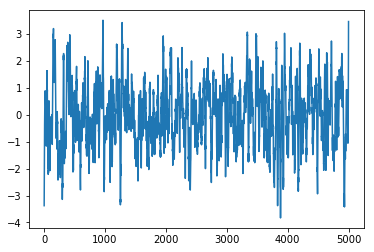

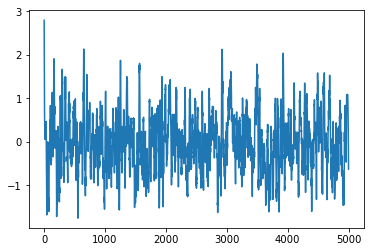

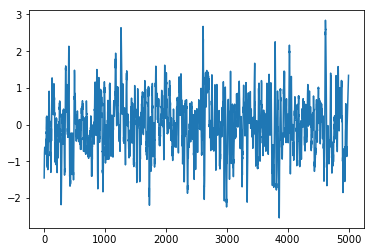

In [13]:
yhat = savgol_filter(savar.network_data[:, 0], 51, 4) # window size 51, polynomial order 3
plt.plot(yhat)
plt.show()
yhat = savgol_filter(savar.network_data[:, 1], 51, 4) # window size 51, polynomial order 3
plt.plot(yhat)
plt.show()
yhat = savgol_filter(savar.network_data[:, 2], 51, 4) # window size 51, polynomial order 3
plt.plot(yhat)
plt.show()